In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from scipy import interpolate, optimize
import astropy.units as u
import astropy.constants as c
from astropy.cosmology import Planck18 as cosmo

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
from dm21cm.injections.pbh import PBHHRInjection
from dm21cm.utils import load_h5_dict, abscs
import dm21cm.physics as phys
from dm21cm.precompute.pbh_hr.read import read_pbh, output_specs

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file(f"{WDIR}/matplotlibrc")

In [2]:
def t_ind(t_s, z):
    t = cosmo.age(z).to(u.s).value
    ind = np.searchsorted(t_s, t) - 1
    return ind

def t_inds(t_s, z_start, z_end):
    t_start = cosmo.age(z_start).to(u.s).value
    ind_t_start = np.searchsorted(t_s, t_start) - 1
    t_end = cosmo.age(z_end).to(u.s).value
    ind_t_end = np.searchsorted(t_s, t_end) + 1
    if ind_t_end >= len(t_s):
        ind_t_end = len(t_s) - 1
    return ind_t_start, ind_t_end

def interp_dNdEdt(t_s, src_E, src_dNdEdt, tar_Ek, mass=0):
    """
    Args:
        t (1D array): time [s]
        src_E (1D array): source total energy (kinetic + mass) [eV]
        src_dNdEdt (2D array): source dNdEdt data. first dimension is time, second is energy [1/eV s]
        tar_Ek (1D array): target kinetic energy [eV]
        mass (float): mass of the particle [eV]
    """
    ind_t_start, ind_t_end = t_inds(t_s, 4000, 5)
    t_sub = t_s[ind_t_start:ind_t_end]
    dNdEdt_sub = np.zeros((len(t_sub), len(tar_Ek)))
    for ind in range(ind_t_start, ind_t_end):
        interp = interpolate.interp1d(src_E, src_dNdEdt[ind], fill_value=0., bounds_error=False)
        dNdEdt_sub[ind-ind_t_start] = interp(tar_Ek + mass)
    return t_sub, dNdEdt_sub

def prepend_zero(eng, arr):
    new_eng = np.insert(eng, 0, eng[0] - 1e-6)
    new_arr = np.insert(arr, 0, 0)
    return new_eng, new_arr


def get_phot_elec_interps(data_dir):

    evol_data = read_pbh(data_dir, 'evolution')
    phot_pri_data = read_pbh(data_dir, 'primary', 'photon')
    elec_pri_data = read_pbh(data_dir, 'primary', 'electron')

    t_phot, dNdEdt_phot = interp_dNdEdt(evol_data['t'], phot_pri_data['E'], phot_pri_data['dN_dEdt'], abscs['photE'], mass=0)
    t_elec, dNdEdt_elec = interp_dNdEdt(evol_data['t'], elec_pri_data['E'], elec_pri_data['dN_dEdt'], abscs['elecEk'], mass=phys.m_e)

    dNdEdt_phot_t_interp = interpolate.interp1d(t_phot, dNdEdt_phot, axis=0, fill_value=0., bounds_error=False)
    dNdEdt_elec_t_interp = interpolate.interp1d(t_elec, dNdEdt_elec, axis=0, fill_value=0., bounds_error=False)

    return dNdEdt_phot_t_interp, dNdEdt_elec_t_interp

In [5]:
BASE_DIR = '/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/blackhawk'

a0_dNdEdt_phot_t_interp, a0_dNdEdt_elec_t_interp = get_phot_elec_interps(BASE_DIR + '/a0.000/m14.500_pri')
a1_dNdEdt_phot_t_interp, a1_dNdEdt_elec_t_interp = get_phot_elec_interps(BASE_DIR + '/a0.999/m14.500_pri')

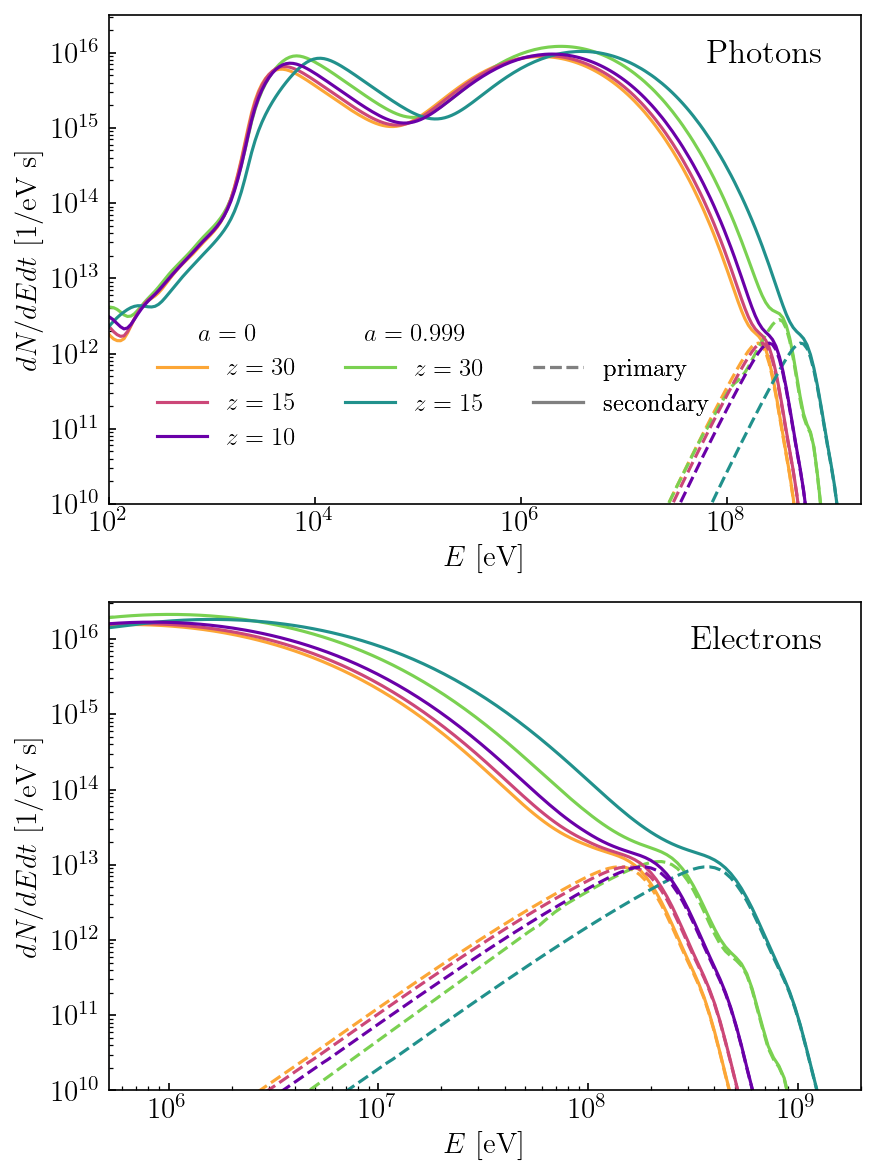

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharey=True)

z_s = [30, 15, 10]
alpha_s = [0.4, 0.7, 1.0]
a0_color_s = mpl.colormaps['plasma']([0.8, 0.5, 0.2])
a1_color_s = mpl.colormaps['viridis']([0.8, 0.5, 0.2])
# ph_color = mpl.colormaps['plasma'](0.85)
# e_color  = mpl.colormaps['plasma'](0.20)

for i, z in enumerate(z_s):

    # primaries
    a0_phot_spec_pri_dNdEdt = a0_dNdEdt_phot_t_interp(cosmo.age(z).to(u.s).value)
    a0_elec_spec_pri_dNdEdt = a0_dNdEdt_elec_t_interp(cosmo.age(z).to(u.s).value)
    a1_phot_spec_pri_dNdEdt = a1_dNdEdt_phot_t_interp(cosmo.age(z).to(u.s).value)
    a1_elec_spec_pri_dNdEdt = a1_dNdEdt_elec_t_interp(cosmo.age(z).to(u.s).value)
    # secondaries
    a0_inj = PBHHRInjection(m_PBH=10**14.5, f_PBH=1, a_PBH=0)
    a0_phot_spec_sec = a0_inj.inj_phot_spec(z) / a0_inj.n_PBH(z)
    a0_elec_spec_sec = a0_inj.inj_elec_spec(z) / a0_inj.n_PBH(z)
    a1_inj = PBHHRInjection(m_PBH=10**14.5, f_PBH=1, a_PBH=0.999)
    a1_phot_spec_sec = a1_inj.inj_phot_spec(z) / a1_inj.n_PBH(z)
    a1_elec_spec_sec = a1_inj.inj_elec_spec(z) / a1_inj.n_PBH(z)

    ax = axs[0]
    ax.plot(abscs['photE'], a0_phot_spec_pri_dNdEdt, color=a0_color_s[i], ls='--', label=None, lw=1.5)
    ax.plot(abscs['photE'], a0_phot_spec_sec.dNdE, color=a0_color_s[i], label=fr'$z={z:d}$', lw=1.5)
    ax.plot(abscs['photE'], a1_phot_spec_pri_dNdEdt, color=a1_color_s[i], ls='--', label=None, lw=1.5)
    ax.plot(abscs['photE'], a1_phot_spec_sec.dNdE, color=a1_color_s[i], label=(fr'$z={z:d}$' if i <=1 else None), lw=1.5)
    ax = axs[1]
    ax.plot(*prepend_zero(abscs['elecEk']+phys.m_e, a0_elec_spec_pri_dNdEdt), color=a0_color_s[i], ls='--', label=None, lw=1.5)
    ax.plot(*prepend_zero(abscs['elecEk']+phys.m_e, a0_elec_spec_sec.dNdE), color=a0_color_s[i], label=fr'$z={z:d}$', lw=1.5)
    ax.plot(*prepend_zero(abscs['elecEk']+phys.m_e, a1_elec_spec_pri_dNdEdt), color=a1_color_s[i], ls='--', label=None, lw=1.5)
    ax.plot(*prepend_zero(abscs['elecEk']+phys.m_e, a1_elec_spec_sec.dNdE), color=a1_color_s[i], label=None, lw=1.5)

ax = axs[0]
ax.plot(0, 0, color='gray', ls='--', label='primary', lw=1.5)
ax.plot(0, 0, color='gray', ls='-', label='secondary', lw=1.5)

ax.set(xscale='log', yscale='log')
ax.set(xlim=(1e2, 2e9), ylim=(1e10, 3.16e16))
ax.set(xlabel=r"$E$ [eV]", ylabel=r"$dN/dEdt$ [1/eV s]")

handles, labels = ax.get_legend_handles_labels()
i1_s = [0, 2, 4] # indices for a0
i2_s = [1, 3] # indices for a1
i3_s = [5, 6] # indices for primary/secondary
hl1 = [handles[i] for i in i1_s], [labels[i] for i in i1_s]
hl2 = [handles[i] for i in i2_s], [labels[i] for i in i2_s]
hl3 = [handles[i] for i in i3_s], [labels[i] for i in i3_s]
ax.add_artist(ax.legend(*hl1, loc=(0.05, 0.09), frameon=False, title=r'$a=0$'))
ax.add_artist(ax.legend(*hl2, loc=(0.30, 0.16), frameon=False, title=r'$a=0.999$'))
ax.add_artist(ax.legend(*hl3, loc=(0.55, 0.16), frameon=False))

ax = axs[1]
ax.set(xscale='log', yscale='log')
ax.set(xlim=(5.2e5, 2e9), ylim=(1e10, 3.16e16))
ax.set(xlabel=r"$E$ [eV]", ylabel=r"$dN/dEdt$ [1/eV s]")

axs[0].text(0.95, 0.95, 'Photons', transform=axs[0].transAxes, ha='right', va='top', fontsize=16)
axs[1].text(0.95, 0.95, 'Electrons', transform=axs[1].transAxes, ha='right', va='top', fontsize=16)
# axs[0].set(title='Photons')
# axs[1].set(title='Electrons')

# axs[1].legend(fontsize=10, frameon=False)

fig.tight_layout()
fig.savefig('../../plotting/paper2/pbh-hr-example-specs.pdf', bbox_inches='tight')

# 1 panel version

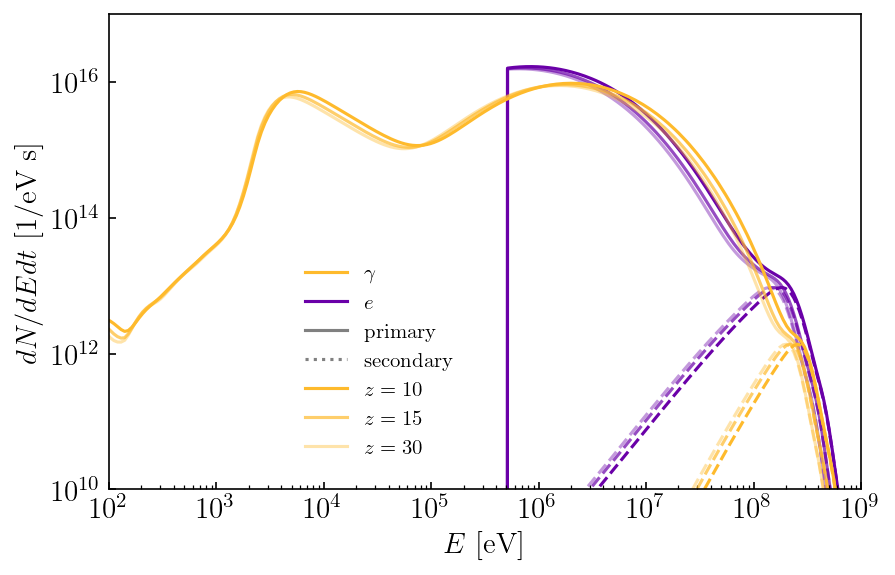

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

z_s = [30, 15, 10]
alpha_s = [0.4, 0.7, 1.0]
ph_color = mpl.colormaps['plasma'](0.85)
e_color  = mpl.colormaps['plasma'](0.20)
ph_zorder, e_zorder = 2, 1

for z, alpha in zip(z_s, alpha_s):

    # primaries
    phot_spec_pri_dNdEdt = dNdEdt_phot_t_interp(cosmo.age(z).to(u.s).value)
    elec_spec_pri_dNdEdt = dNdEdt_elec_t_interp(cosmo.age(z).to(u.s).value)
    # secondaries
    inj = PBHHRInjection(m_PBH=10**14.5, f_PBH=1)
    phot_spec_sec = inj.inj_phot_spec(z) / inj.n_PBH(z)
    elec_spec_sec = inj.inj_elec_spec(z) / inj.n_PBH(z)

    ax.plot(abscs['photE'], phot_spec_pri_dNdEdt, color=ph_color, ls='--', alpha=alpha, label=None, lw=1.5, zorder=ph_zorder)
    ax.plot(abscs['photE'], phot_spec_sec.dNdE, color=ph_color, alpha=alpha, label=(r'$\gamma$' if alpha==1 else None), lw=1.5, zorder=ph_zorder)
    ax.plot(*prepend_zero(abscs['elecEk']+phys.m_e, elec_spec_pri_dNdEdt), color=e_color, ls='--', alpha=alpha, label=None, lw=1.5, zorder=e_zorder)
    ax.plot(*prepend_zero(abscs['elecEk']+phys.m_e, elec_spec_sec.dNdE), color=e_color, alpha=alpha, label=(r'$e$' if alpha==1 else None), lw=1.5, zorder=e_zorder)

ax.plot(0, 0, color='gray', label='primary', lw=1.5)
ax.plot(0, 0, color='gray', ls=':', label='secondary', lw=1.5)
for z, alpha in zip(z_s[::-1], alpha_s[::-1]):
    ax.plot(0, 0, color=ph_color, alpha=alpha, label=fr'$z={z}$', lw=1.5)

ax.set(xscale='log', yscale='log')
ax.set(xlim=(1e2, 1e9), ylim=(1e10, 1e17))
ax.set(xlabel=r"$E$ [eV]", ylabel=r"$dN/dEdt$ [1/eV s]")

ax.legend(fontsize=10, loc=(0.25, 0.05), frameon=False)

fig.tight_layout()
# fig.savefig('../../plotting/paper2/pbh-hr-example-spec.pdf', bbox_inches='tight')

In [7]:
diff = lambda z: np.abs(t_phot[-1]-cosmo.age(z).to(u.s).value)
res = optimize.minimize(diff, 10, bounds=[(0, 30)], method='L-BFGS-B')
z_evap = res.x[0]
print(z_evap, cosmo.age(z_evap).to(u.s).value, t_phot[-1])

6.749894528889925 2.5173800014028124e+16 2.51738e+16
